# Description

Initial EDA for potential propensity score matching leakage.

In [1]:
# source: https://stackoverflow.com/a/28073228
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

from ipywidgets import interact

%matplotlib inline

# Load data

## Kitsios 2015

The `psm_leakage_kitsios2015.csv` file was collected from Supplementary Figure 2 of Kidsios et al. "Can we trust observational studies using propensity scores in the critical care
literature? A systematic comparison with randomized clinical trials."

- [[Supplementary Material link](https://links.lww.com/CCM/B327)]

In [3]:
psm_leak = pd.read_csv("data/psm_leakage_kitsios2015.csv")

# create a unique study id via index
psm_leak = psm_leak.reset_index()
psm_leak = psm_leak.rename({"index": "study_id"}, axis="columns")
psm_leak['study_id'] = psm_leak['study_id'].astype(str)
psm_leak.head()
psm_leak['ci_diff'] = psm_leak['upper_ci'] - psm_leak['lower_ci']

In [4]:
psm_leak['study_type'].value_counts()

RCT    62
PS     27
Name: study_type, dtype: int64

## Hemkens 2016

The Hemkens et al. 2016 data contains pooled RCT information for RCTs that only follow PS studies.

In [5]:
psm_leak = pd.read_csv("data/psm_leakage_hemkens2016.csv")

# create a unique study id via index
psm_leak = psm_leak.reset_index()
psm_leak = psm_leak.rename({"index": "study_id"}, axis="columns")
psm_leak['study_id'] = psm_leak['study_id'].astype(str)
psm_leak.head()
psm_leak['ci_diff'] = psm_leak['upper_ci'] - psm_leak['lower_ci']

In [6]:
psm_leak['study_type'].value_counts()

PS     16
RCT    16
Name: study_type, dtype: int64

# Clip studies with large CIs

During a live coding session, Konrad and I examined the confidence intervals
and decided to remove studies with large intervals -- the choice of 3 as the cutoff
was arbitrary based on visual inspection and more formal analysis will need a more formal method for outlier
removal (e.g. 2-3 SDs).

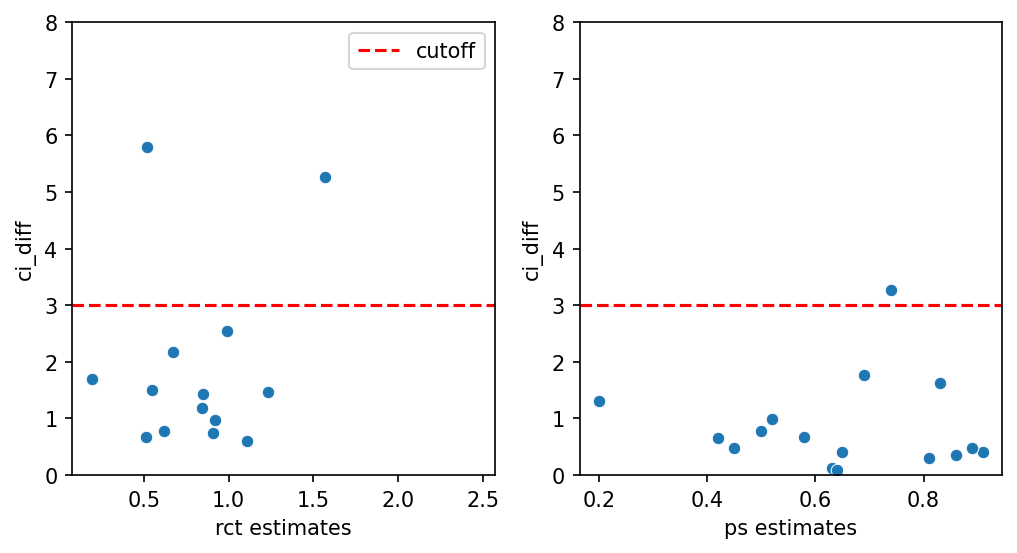

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=150, figsize=(8,4))
rct = psm_leak[psm_leak['study_type'] == 'RCT']
ps = psm_leak[psm_leak['study_type'] == 'PS']

sns.scatterplot(data=rct, x='estimate', y='ci_diff', ax=ax1)
ax1.set_ylim(0, 8)
ax1.set_xlabel("rct estimates")
ax1.axhline(y=3, ls='--', color='red', label='cutoff')
ax1.legend()

sns.scatterplot(data=ps, x='estimate', y='ci_diff', ax=ax2)
ax2.set_ylim(0, 8)
ax2.axhline(y=3, ls='--', color='red', label='cutoff')
ax2.set_xlabel("ps estimates");


In [8]:
sel_psm_leak = psm_leak[psm_leak['ci_diff'] < 3]

# Compute pairwise differences

For each PS study within a clinical setting, we pair it with an RCT and compute
the year difference between each pair.

**TODO**: since this is a one-to-many mapping *per PS study*, there will be 
repeated measurements of both PS and RCT studies. More formal analysis will need
to account for this group structure.

In [9]:
pair_df = pd.DataFrame()
for clinic_set, group in sel_psm_leak.groupby("clinical_setting"):
    ps_df = group[group['study_type'] == 'PS']
    rct_df = group[group['study_type'] == 'RCT']
    for ps_idx, ps in ps_df.iterrows():
        ps_dict = {
            "study_id": [],
            "rct_year": [],
            "ps_year": [],
            "year_diff": [],
            "rct_est": [],
            "ps_est": [],
            "clinical_setting": [],
            'rct_ci_diff': []
        }
        for rct_idx, rct in rct_df.iterrows():
            ps_dict['study_id'].append(ps['study_id'])
            ps_dict['ps_year'].append(ps['year'])
            ps_dict['rct_year'].append(rct['year'])
            ps_dict['year_diff'].append(ps['year'] - rct['year'])
            ps_dict['rct_est'].append(rct['estimate'])
            ps_dict['ps_est'].append(ps['estimate'])
            ps_dict['clinical_setting'].append(ps['clinical_setting'])
            ps_dict['rct_ci_diff'].append(rct['ci_diff'])
        
        df = pd.DataFrame.from_dict(ps_dict)
        pair_df = pair_df.append(df)

Some sanity check assertions:

In [10]:
# examine the first PS (study id 5)
sel_psm_leak.head(6)

,study_id,study_type,year,clinical_setting,estimate,lower_ci,upper_ci,ci_diff
0,0,PS,2016,Preincision prophylactic intra-aortic balloon ...,0.91,0.74,1.15,0.41
1,1,RCT,2017,Preincision prophylactic intra-aortic balloon ...,0.67,0.19,2.36,2.17
2,2,PS,2016,"On pump v off pump CABG, CABG, severe left ven...",0.69,0.24,2.00,1.76
4,4,PS,2016,"Off pump v on pump CABG, CABG, non-elective",0.83,0.36,1.99,1.63
5,5,RCT,2017,"Off pump v on pump CABG, CABG, non-elective",0.19,0.02,1.71,1.69
6,6,PS,2016,"Hemodialysis v peritoneal dialysis, Renal repl...",0.86,0.70,1.06,0.36


# Relationship between RCT and PS estimates: regression

We'll analyze the effect estimates in log space.

In [12]:
pair_df['rct_est'] = np.log(pair_df['rct_est'])
pair_df['ps_est'] = np.log(pair_df['ps_est'])

For the initial analysis, we discard PS-RCT pairs that were published in the same year.

**TODO**: further data collection could take a look at the specific studies cited
and their specific month/day publication date for more granularity.

In [13]:
no_zero_pairs = pair_df[pair_df['year_diff'] != 0].copy()

In [14]:
# indicator function for the PS study coming *after* the RCT
no_zero_pairs['ps_after'] = (no_zero_pairs['year_diff'] > 0).astype(int)

In [15]:
# helper function for regression results
def get_reg_results(data, name, x, y='rct_est'):
    sel_cols = ['names', 'coef', 'se', 'pval', 'CI[2.5%]', 'CI[97.5%]']
    # we want the second entry, for the x coefficient results
    reg_results = pg.linear_regression(data[x], data[y], add_intercept=True).loc[1, sel_cols]
    reg_results = reg_results.to_frame().transpose()
    reg_results.index = [name]
    return reg_results

#get_reg_results(no_zero_pairs[no_zero_pairs['ps_after'] == 0], 'test', x='ps_est')

In [19]:
group_col = 'study_id'

@interact(
    group_col = ['study_id', 'clinical_setting']
)
def show_reg(group_col):
    fig, (ax1,ax2) = plt.subplots(1, 2, dpi=125, figsize=(10,4))

#     sns.scatterplot(data=no_zero_pairs, x='ps_est', y='rct_est', hue='ps_after', ax=ax1)
#     sns.regplot(data=no_zero_pairs[no_zero_pairs['ps_after'] == 0], x='ps_est', y='rct_est', color='blue', ax=ax1)
#     sns.regplot(data=no_zero_pairs[no_zero_pairs['ps_after'] == 1], x='ps_est', y='rct_est', color='orange', ax=ax1)
#     ax1.set_title("outlier clipped, individual pairs")
#     ax1.set_xlabel("log PS study effect estimate")
#     ax1.set_ylabel("log RCT study effect estimate")
#     ax1.set_ylim(-1.25, 0.75)

    #grouped = no_zero_pairs.sort_values(by=[group_col, 'rct_ci_diff'], ascending=True).groupby(['ps_after', group_col], as_index=False)[['ps_est', 'rct_est']].head()
    grouped = no_zero_pairs.groupby(['ps_after', group_col], as_index=False)[['ps_est', 'rct_est']].mean()
    print(f"{no_zero_pairs.shape[0]} individual pairs")
    print(f"{grouped.shape[0]} grouped pairs")
    
    
    sns.scatterplot(data=grouped, x='ps_est', y='rct_est', hue='ps_after', ax=ax2)
    sns.regplot(data=grouped[grouped['ps_after'] == 0], x='ps_est', y='rct_est', color='blue', ax=ax2)
    sns.regplot(data=grouped[grouped['ps_after'] == 1], x='ps_est', y='rct_est', color='orange', ax=ax2)
    ax2.set_title(f"outlier clipped, grouped by {group_col}")
    ax2.set_xlabel("log PS study effect estimate")
    ax2.set_ylabel("log RCT study effect estimate")
    ax2.set_ylim(-1.25, 0.75)

    # show regression results
    name_dict = {
        'individual pairs, before': no_zero_pairs[no_zero_pairs['ps_after'] == 0],
        'individual pairs, after': no_zero_pairs[no_zero_pairs['ps_after'] == 1],
        'grouped pairs, before': grouped[grouped['ps_after'] == 0],
        'grouped pairs, after': grouped[grouped['ps_after'] == 1],
    }

    reg_df = pd.DataFrame()
    for name, data in name_dict.items():
        if data.shape[0] > 0:
            df = get_reg_results(data, name, x='ps_est', y='rct_est')
            reg_df = reg_df.append(df)

    display(reg_df)

interactive(children=(Dropdown(description='group_col', options=('study_id', 'clinical_setting'), value='study…